# Deteksi Fibrilasi Atrium dengan Pendekatan Machine Learning berbasis Sinyal EKG

Akan dilakukan percobaan untuk menguji 3 algoritma klasifikasi berbeda yaitu Extreme Learning Machine (ELM), Relevance Vector Machine (RVM), dan Self-Organizing Maps (SOM). Analisis akan dilakukan terhadap model yang sudah dirancang dengan parameter default dan parameter tuning.

# Proses Pengambilan Data


## Mengonversi Data

Melakukan konversi data MIT-BIH Atrial Fibrillation Database (AFDB) yang sudah dibaca dengan library WFDB menjadi file .csv, dilanjutkan dengan pemilahan data berdasarkan anotasi AFIB dan Normal

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import neurokit2 as nk
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import joblib
from hpelm import ELM
from sklearn_rvm import EMRVC
from minisom import MiniSom

In [2]:
sampel = ['04015', '04043', '04048', '04126', '04746',
          '04908', '04936', '05091', '05121', '05261',
          '06426', '06453', '06995', '07162', '07859',
          '07879', '07910', '08215', '08219', '08378',
          '08405', '08434', '08455']

path = 'drive/MyDrive'
jumlah_data = 0
afib = 0
n = 0

for sampels in sampel:
    record_name = f'{path}/AFDB/{sampels}'
    record = wfdb.rdsamp(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    data = pd.DataFrame(record[0])
    anotasi = annotation.sample
    tipe = annotation.aux_note

    for i in range(len(anotasi)-1):
        data_cut = data.iloc[anotasi[i]:anotasi[i+1]]
        if tipe[i] == '(N':
            file_path = f'{path}/Data/Normal/{anotasi[i]}.csv'
            jumlah_data = jumlah_data + 1
            n = n + 1
        elif tipe[i] == '(AFIB':
            file_path = f'{path}/Data/AFIB/{anotasi[i]}.csv'
            jumlah_data = jumlah_data + 1
            afib = afib + 1
        else:
            file_path = f'{path}/Data/Temp/{anotasi[i]}.csv'

        if not os.path.exists(file_path):
            data_cut.to_csv(file_path, index=False)
        else:
            if tipe[i] == '(N':
                file_path = f'{path}/Data/Normal/{anotasi[i]}_1.csv'
            elif tipe[i] == '(AFIB':
                file_path = f'{path}/Data/AFIB/{anotasi[i]}_1.csv'
            else:
                file_path = f'{path}/Data/Temp/{anotasi[i]}_1.csv'
            data_cut.to_csv(file_path, index=False)

print(f"Jumlah Data Keseluruhan : {jumlah_data}")
print(f"Jumlah Data AFIB        : {afib}")
print(f"Jumlah Data N           : {n}")

Jumlah Data Keseluruhan : 557
Jumlah Data AFIB        : 283
Jumlah Data N           : 274


# Proses Preprocessing Data

In [3]:
import os
import pandas as pd
import neurokit2 as nk

In [4]:
def load_ecg_data(folder_path):
    ecg_data = {}
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            ecg_data[file] = df.iloc[:, 0].values
    return ecg_data

def preprocess_ecg(folder_path):
    ecg_data = load_ecg_data(folder_path)
    processed_data = {}

    for filename, ecg_signal in ecg_data.items():
        filtered_ecg = nk.ecg_clean(ecg_signal, sampling_rate=250, method="neurokit")
        processed_data[filename] = filtered_ecg
    return processed_data

folder = ['AFIB', 'Normal']
path = 'drive/MyDrive'

for folders in folder:
    folder_path = f'{path}/Data/{folders}'
    new_folder_path = f'{path}/Data/{folders}/Processed'

    preprocessed_ecg = preprocess_ecg(folder_path)

    for filename, processed_signal in preprocessed_ecg.items():
        output_filename = f"{filename}"
        output_path = os.path.join(new_folder_path, output_filename)
        pd.DataFrame(processed_signal, columns=['ECG']).to_csv(output_path, index=False)

    print(f'{folders} Selesai!')
print('Semua data sudah selesai di Preprocess!')

AFIB Selesai!
Normal Selesai!
Semua data sudah selesai di Preprocess!


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

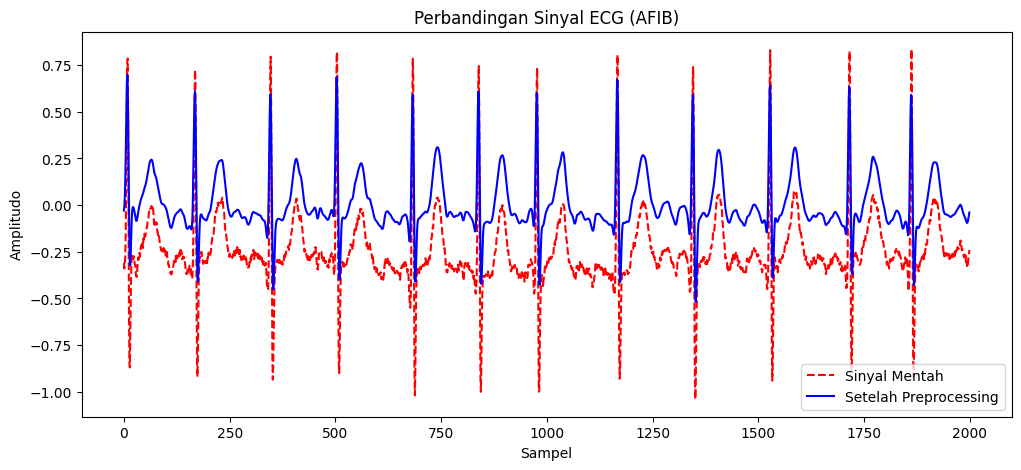

In [6]:
path = 'drive/MyDrive'

ecg_signal_1 = pd.read_csv(f'{path}/Data/AFIB/7.csv')
ecg_signal_2 = pd.read_csv(f'{path}/Data/AFIB/Processed/7.csv')

signal_1 = ecg_signal_1['0'].values[:2000]
signal_2 = ecg_signal_2['ECG'].values[:2000]

# Visualisasi
plt.figure(figsize=(12, 5))
plt.plot(signal_1, color='red', label='Sinyal Mentah', linestyle='--')
plt.plot(signal_2, color='blue', label='Setelah Preprocessing')
plt.title('Perbandingan Sinyal ECG (AFIB)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

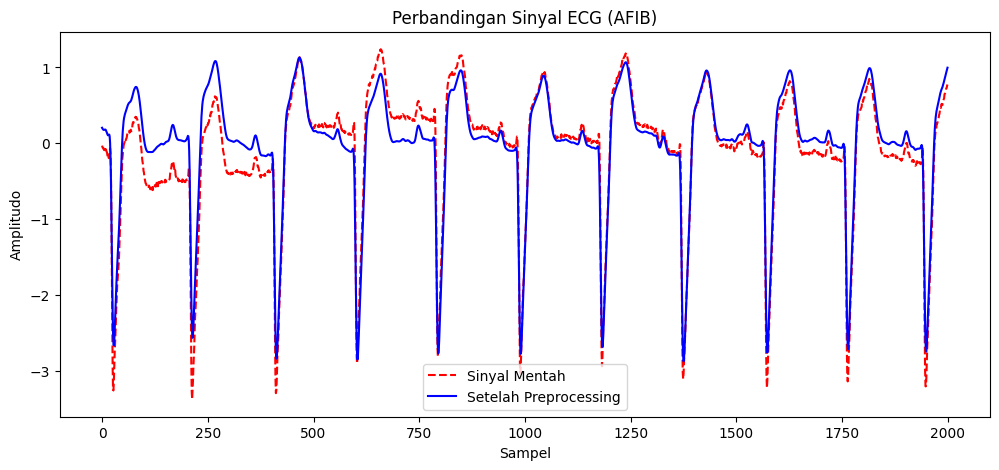

In [7]:
path = 'drive/MyDrive'

ecg_signal_1 = pd.read_csv(f'{path}/Data/Normal/28.csv')
ecg_signal_2 = pd.read_csv(f'{path}/Data/Normal/Processed/28.csv')

signal_1 = ecg_signal_1['0'].values[:2000]
signal_2 = ecg_signal_2['ECG'].values[:2000]

# Visualisasi
plt.figure(figsize=(12, 5))
plt.plot(signal_1, color='red', label='Sinyal Mentah', linestyle='--')
plt.plot(signal_2, color='blue', label='Setelah Preprocessing')
plt.title('Perbandingan Sinyal ECG (AFIB)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

# Proses Ekstraksi Fitur

Tahapan yang dilakukan pada proses ini adalah:
1.   Mencari titik R menggunakan algoritma Pan & Tompkins (1985)
2.   Menghitung R-R Interval dalam satuan milidetik
3.   Melakukan perhitungan statistik terhadap R-R Interval untuk mendapat kan nilai Min, Max, Mean, Median, dan Standar Deviasi

In [8]:
import pandas as pd
import neurokit2 as nk
import numpy as np
import os

In [9]:
folder = ['AFIB', 'Normal']
path = 'drive/MyDrive'

for folders in folder:
    folder_path = f'{path}/Data/{folders}/Processed'

    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            ekg_signal = data['ECG'].values
            sampling_rate = 250
            cleaned_signal = nk.ecg_clean(ekg_signal, sampling_rate=sampling_rate, method="pantompkins1985")
            r_peaks = nk.ecg_findpeaks(cleaned_signal, sampling_rate=sampling_rate)
            rr_intervals_ms = np.diff(r_peaks['ECG_R_Peaks']) / sampling_rate * 1000

            min_rr = np.min(rr_intervals_ms)
            max_rr = np.max(rr_intervals_ms)
            mean_rr = np.mean(rr_intervals_ms)
            median_rr = np.median(rr_intervals_ms)
            std_rr = np.std(rr_intervals_ms)

            if folders == 'AFIB':
                results.append({
                    'Min': min_rr,
                    'Max': max_rr,
                    'Mean' : mean_rr,
                    'Median':median_rr,
                    'Std': std_rr,
                    'Label' : '1'
                })
            else:
                results.append({
                    'Min': min_rr,
                    'Max': max_rr,
                    'Mean' : mean_rr,
                    'Median':median_rr,
                    'Std': std_rr,
                    'Label' : '0'
                })

        results_df = pd.DataFrame(results)
        results_df.to_csv(f'Fitur{folders}.csv', index=False)
    print(f"Hasil ekstraksi fitur {folders} telah disimpan!")
print('Selesai!')

Hasil ekstraksi fitur AFIB telah disimpan!
Hasil ekstraksi fitur Normal telah disimpan!
Selesai!


In [10]:
data = pd.read_csv('FiturAFIB.csv')
print(data.head())

     Min     Max        Mean  Median         Std  Label
0  308.0   912.0  458.122449   436.0  111.665493      1
1  520.0   552.0  536.000000   536.0   16.000000      1
2  308.0  1004.0  464.013937   448.0  109.734935      1
3  304.0   720.0  452.000000   440.0   99.512659      1
4  352.0   692.0  454.444444   460.0   67.483514      1


In [11]:
data = pd.read_csv('FiturNormal.csv')
print(data.head())

     Min     Max        Mean  Median         Std  Label
0  312.0  2872.0  678.733002   608.0  245.812235      0
1  376.0   936.0  672.666667   622.0  207.421203      0
2  468.0  1056.0  628.228571   582.0  127.139762      0
3  304.0  1628.0  738.778772   764.0  108.825106      0
4  308.0  1264.0  732.118812   800.0  136.258875      0


# Proses Klasifikasi Menggunakan Parameter Default

## Pembagian Data Latih dan Data Uji

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [13]:
data_afib = pd.read_csv('FiturAFIB.csv')
data_normal = pd.read_csv('FiturNormal.csv')

data_combine = pd.concat([data_normal, data_afib], ignore_index=True)

X = data_combine.iloc[:, :-1]
y = data_combine.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
train_data.to_csv('Data_Latih.csv', index=False)

test_data = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_data.to_csv('Data_Uji.csv', index=False)

print(f'Jumlah Data Latih : {X_train.shape[0]}')
print(f'Jumlah Data Uji   : {X_test.shape[0]}')

Jumlah Data Latih : 445
Jumlah Data Uji   : 112


## Klasifikasi Algoritma ELM dengan Parameter Default

### Proses Training

In [14]:
data = pd.read_csv('Data_Latih.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

    model = ELM(X_train.shape[1], y_train_onehot.shape[1])
    model.add_neurons(5, 'sigm')
    model.train(X_train, y_train_onehot)

    model.save(f'Model/ELM/Default/ELM_Default_{fold_no}.h5')

    y_pred_onehot = model.predict(X_test)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(hasil)


Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  86.516854     84.782609     88.372093  86.666667
1     2  88.764045     94.339623     80.555556  90.909091
2     3  93.258427     90.909091     94.642857  90.909091
3     4  79.775281     97.560976     64.583333  81.632653
4     5  87.640449     92.452830     80.555556  89.908257


### Proses Testing

In [15]:
parameter = 'Default'
fold = [1, 2, 3, 4, 5]

data_test = pd.read_csv('Data_Uji.csv')

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

encoder = OneHotEncoder(sparse_output=False)
y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

results = []

for folds in fold:
    model = ELM(X_test.shape[1], y_test_onehot.shape[1])
    model.load(f'Model/ELM/Default/ELM_{parameter}_{folds}.h5')

    y_pred_onehot = model.predict(X_test)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold' : folds,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir :")
print(hasil)


Hasil Akhir :
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  83.928571     80.701754     87.272727  83.636364
1     2  83.035714     80.701754     85.454545  82.882883
2     3  86.607143     89.473684     83.636364  87.179487
3     4  84.821429     98.245614     70.909091  86.821705
4     5  83.928571     94.736842     72.727273  85.714286


## Klasifikasi Algoritma RVM dengan Parameter Default

### Proses Training

In [16]:
data = pd.read_csv('Data_Latih.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model = EMRVC(gamma='auto')
    model.fit(X_train, y_train)

    joblib.dump(model, f'Model/RVM/Default/RVM_Default_{fold_no}.pkl')

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(hasil)


Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  92.134831     97.826087     86.046512  92.783505
1     2  92.134831     94.339623     88.888889  93.457944
2     3  94.382022     93.939394     94.642857  92.537313
3     4  91.011236     95.121951     87.500000  90.697674
4     5  95.505618     94.339623     97.222222  96.153846


### Proses Testing

In [17]:
parameter = 'Default'
fold = [1, 2, 3, 4, 5]

data_test = pd.read_csv('Data_Uji.csv')

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

results = []

for folds in fold:
    model = joblib.load(f'Model/RVM/Default/RVM_{parameter}_{folds}.pkl')

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold' : folds,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir :")
print(hasil)


Hasil Akhir :
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  90.178571     91.228070     89.090909  90.434783
1     2  90.178571     91.228070     89.090909  90.434783
2     3  93.750000     96.491228     90.909091  94.017094
3     4  93.750000     98.245614     89.090909  94.117647
4     5  91.071429     94.736842     87.272727  91.525424


## Klasifikasi Algoritma SOM dengan Parameter Default

### Proses Training

In [18]:
data = pd.read_csv('Data_Latih.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5)
    som.train(X_train, num_iteration=100)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    win_map = {}
    for i, x in enumerate(X_train):
        w = som.winner(x)
        if w not in win_map:
            win_map[w] = []
        win_map[w].append(y_train[i])

    y_pred = []
    for x in X_test:
        w = som.winner(x)
        if w in win_map:
            y_pred.append(np.bincount(win_map[w]).argmax())
        else:
            y_pred.append(0)

    y_pred = np.array(y_pred)
    joblib.dump(som._weights, f'Model/SOM/Default/SOM_Default_{fold_no}.pkl')
    joblib.dump(win_map, f'Model/SOM/Default/WinMap_Default_{fold_no}.pkl')
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    results.append({
        'Fold': fold_no,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(hasil)


Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  86.516854     82.608696     90.697674  86.363636
1     2  86.516854     86.792453     86.111111  88.461538
2     3  91.011236     87.878788     92.857143  87.878788
3     4  87.640449     90.243902     85.416667  87.058824
4     5  92.134831     90.566038     94.444444  93.203883


### Proses Testing

In [19]:
parameter = 'Default'
fold = [1, 2, 3, 4, 5]

data_test = pd.read_csv('Data_Uji.csv')

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

results = []

for folds in fold:
    weights = joblib.load(f'Model/SOM/Default/SOM_{parameter}_{folds}.pkl')
    win_map = joblib.load(f'Model/SOM/Default/WinMap_{parameter}_{folds}.pkl')

    som = MiniSom(x=5, y=5, input_len=X_test.shape[1], sigma=1.0, learning_rate=0.1)
    som._weights = np.array(weights)

    y_pred = []
    for x in X_test:
        w = som.winner(x)
        if w in win_map:
            y_pred.append(np.bincount(win_map[w]).argmax())
        else:
            y_pred.append(0)

    y_pred = np.array(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold' : folds,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir :")
print(hasil)


Hasil Akhir :
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  85.714286     78.947368     92.727273  84.905660
1     2  85.714286     84.210526     87.272727  85.714286
2     3  88.392857     91.228070     85.454545  88.888889
3     4  89.285714     91.228070     87.272727  89.655172
4     5  89.285714     89.473684     89.090909  89.473684


# Proses Klasifikasi Menggunakan Parameter Tuning

## Klasifikasi Algoritma ELM dengan Parameter Tuning

### Parameter Grid Search

In [29]:
data = pd.read_csv('Data_Latih.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_neurons': [1, 2, 3, 4, 5],
    'activation': ["lin", "tanh", "rbf_l1", "rbf_l2", "rbf_linf"]
}

best_accuracy = 0
best_params = {}
n_input = X_train.shape[1]

encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
n_output = y_train_onehot.shape[1]

for n_neurons in param_grid['n_neurons']:
    for activation in param_grid['activation']:
        try:
            model = ELM(n_input, n_output)
            model.add_neurons(n_neurons, activation)
            model.train(X_train, y_train_onehot)

            y_pred_onehot = model.predict(X_test)
            y_pred = np.argmax(y_pred_onehot, axis=1)

            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_neurons': n_neurons, 'activation': activation}

        except Exception as e:
            accuracy = 0

print(f"Parameter Terbaik : {best_params}")
print(f"Akurasi Terbaik   : {best_accuracy}")


Parameter Terbaik : {'n_neurons': 5, 'activation': 'lin'}
Akurasi Terbaik   : 0.898876404494382


### Proses Training

In [30]:
data = pd.read_csv('Data_Latih.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))

    model = ELM(X_train.shape[1], y_train_onehot.shape[1])
    model.add_neurons(5, 'lin')
    model.train(X_train, y_train_onehot)

    model.save(f'Model/ELM/Tuning/ELM_Tuning_{fold_no}.h5')

    y_pred_onehot = model.predict(X_test)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(hasil)


Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  89.887640     91.304348     88.372093  90.322581
1     2  91.011236     96.226415     83.333333  92.727273
2     3  92.134831     87.878788     94.642857  89.230769
3     4  83.146067     92.682927     75.000000  83.516484
4     5  87.640449     84.905660     91.666667  89.108911


### Proses Testing

In [31]:
parameter = 'Tuning'
fold = [1, 2, 3, 4, 5]

data_test = pd.read_csv('Data_Uji.csv')

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

encoder = OneHotEncoder(sparse_output=False)
y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

results = []

for folds in fold:
    model = ELM(X_test.shape[1], y_test_onehot.shape[1])
    model.load(f'Model/ELM/Tuning/ELM_{parameter}_{folds}.h5')

    y_pred_onehot = model.predict(X_test)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold' : folds,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir :")
print(hasil)


Hasil Akhir :
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  87.500000     91.228070     83.636364  88.135593
1     2  87.500000     92.982456     81.818182  88.333333
2     3  84.821429     87.719298     81.818182  85.470085
3     4  90.178571     96.491228     83.636364  90.909091
4     5  88.392857     91.228070     85.454545  88.888889


## Klasifikasi Algoritma RVM dengan Parameter Tuning

### Parameter Grid Search

In [23]:
data = pd.read_csv('Data_Latih.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kernel = ['linear', 'rbf']
gamma = [0.1, 1, 10, 'auto']

best_accuracy = 0
best_params = {}

for kernels in kernel:
    for gammas in gamma:
        try:
            model = EMRVC(kernel=kernels, gamma=gammas)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_pred = np.round(y_pred)

            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'kernel': kernels, 'gamma': gammas}
        except Exception as e:
            accuracy = 0

print(f"Parameter terbaik: {best_params}")
print(f"Akurasi terbaik: {best_accuracy}")

Parameter terbaik: {'kernel': 'rbf', 'gamma': 0.1}
Akurasi terbaik: 0.9213483146067416


### Proses Training

In [24]:
data = pd.read_csv('Data_Latih.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model = EMRVC(kernel='rbf', gamma=0.1)
    model.fit(X_train, y_train)

    joblib.dump(model, f'Model/RVM/Tuning/RVM_Tuning_{fold_no}.pkl')

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(hasil)


Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  92.134831     97.826087     86.046512  92.783505
1     2  92.134831     94.339623     88.888889  93.457944
2     3  94.382022     93.939394     94.642857  92.537313
3     4  91.011236     92.682927     89.583333  90.476190
4     5  97.752809     96.226415    100.000000  98.076923


### Proses Testing

In [25]:
parameter = 'Tuning'
fold = [1, 2, 3, 4, 5]

data_test = pd.read_csv('Data_Uji.csv')

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

results = []

for folds in fold:
    model = joblib.load(f'Model/RVM/Tuning/RVM_{parameter}_{folds}.pkl')

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold' : folds,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir :")
print(hasil)


Hasil Akhir :
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  89.285714     92.982456     85.454545  89.830508
1     2  89.285714     87.719298     90.909091  89.285714
2     3  91.071429     96.491228     85.454545  91.666667
3     4  93.750000     96.491228     90.909091  94.017094
4     5  93.750000     96.491228     90.909091  94.017094


## Klasifikasi Algoritma SOM dengan Parameter Tuning

### Parameter Grid Search

In [26]:
grid_sizes = [(5, 5), (10, 10), (15, 15)]
sigmas = [1.0, 1.5, 2.0]
learning_rates = [0.5, 0.1, 0.05, 0.01]
iterations = [100, 200, 300, 400, 500]

data = pd.read_csv('Data_Latih.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = None
best_accuracy = 0
best_params = None

for grid_size in grid_sizes:
    for sigma in sigmas:
        for learning_rate in learning_rates:
            for iteration in iterations:
                som = MiniSom(x=grid_size[0], y=grid_size[1], input_len=X_train.shape[1], sigma=sigma, learning_rate=learning_rate)
                som.train(X_train, num_iteration=iteration)

                predictions = []
                for sample in X_test:
                    win = som.winner(sample)
                    predictions.append(win)

                predictions = np.array(predictions)
                predicted_classes = np.array([np.argmax(np.bincount(predictions[:,0])) for i in range(len(predictions))])

                accuracy = accuracy_score(y_test, predicted_classes)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = som
                    best_params = {'grid_size': grid_size, 'learning_rate': learning_rate, 'sigma': sigma, 'iterations': iteration}

print(f"Best Model Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")


Best Model Parameters: {'grid_size': (5, 5), 'learning_rate': 0.5, 'sigma': 1.0, 'iterations': 100}
Best Accuracy: 0.5168539325842697


### Proses Training

In [32]:
data = pd.read_csv('Data_Latih.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    som = MiniSom(x=5, y=5, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5)
    som.train(X_train, num_iteration=100)

    win_map = {}
    for i, x in enumerate(X_train):
        w = som.winner(x)
        if w not in win_map:
            win_map[w] = []
        win_map[w].append(y_train[i])

    y_pred = []
    for x in X_test:
        w = som.winner(x)
        if w in win_map:
            y_pred.append(np.bincount(win_map[w]).argmax())
        else:
            y_pred.append(0)

    y_pred = np.array(y_pred)

    joblib.dump(som._weights, f'Model/SOM/Tuning/SOM_Tuning_{fold_no}.pkl')
    joblib.dump(win_map, f'Model/SOM/Tuning/WinMap_Tuning_{fold_no}.pkl')

    accuracy = np.mean(y_pred.flatten() == y_test)


    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(hasil)


Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  88.764045     91.304348     86.046512  89.361702
1     2  91.011236     94.339623     86.111111  92.592593
2     3  89.887640     87.878788     91.071429  86.567164
3     4  86.516854     97.560976     77.083333  86.956522
4     5  87.640449     90.566038     83.333333  89.719626


### Proses Testing

In [34]:
parameter = 'Tuning'
fold = [1, 2, 3, 4, 5]

data_test = pd.read_csv('Data_Uji.csv')

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

results = []

for folds in fold:
    weights = joblib.load(f'Model/SOM/Tuning/SOM_{parameter}_{folds}.pkl')
    win_map = joblib.load(f'Model/SOM/Tuning/WinMap_{parameter}_{folds}.pkl')

    som = MiniSom(x=5, y=5, input_len=X_test.shape[1], sigma=1.0, learning_rate=0.1)
    som._weights = np.array(weights)

    y_pred = []
    for x in X_test:
        w = som.winner(x)
        if w in win_map:
            y_pred.append(np.bincount(win_map[w]).argmax())
        else:
            y_pred.append(0)

    y_pred = np.array(y_pred)
    accuracy = np.mean(y_pred.flatten() == y_test)

    TP = np.sum((y_pred.flatten() == 1) & (y_test == 1))
    TN = np.sum((y_pred.flatten() == 0) & (y_test == 0))
    FP = np.sum((y_pred.flatten() == 1) & (y_test == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test == 1))

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    results.append({
        'Fold' : folds,
        'Akurasi': accuracy * 100,
        'Sensitivitas': sensitivity * 100,
        'Spesifisitas': specificity * 100,
        'F1 Score': f1_score * 100
    })

hasil = pd.DataFrame(results)
print("\nHasil Akhir :")
print(hasil)


Hasil Akhir :
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  85.714286     92.982456     78.181818  86.885246
1     2  87.500000     92.982456     81.818182  88.333333
2     3  85.714286     96.491228     74.545455  87.301587
3     4  87.500000     94.736842     80.000000  88.524590
4     5  88.392857     91.228070     85.454545  88.888889
